In [2]:
import os
import json
import torch

# 最终求解目标是，在满足期望约束的情况下，让前N抽达成抽卡目标的概率尽可能地小，以分析最坏情况下的抽卡成本

CHARACTER_BASE_PROB = 0.007
CHARACTER_DEPTH = 80
CHARACTER_EXP = 1 / 0.0182

WEAPON_BASE_PROB = 0.007
WEAPON_DEPTH = 60
WEAPON_EXP = 1 / 0.0237

DEVICE = "cuda"

# 最终概率分布是Params[0],(1-Params[0])*Params[1],(1-Params[0])*(1-Params[1])*Params[2]...
def GetDistribution(params):
    probs = torch.zeros(params.size(0) + 1, device=DEVICE)
    probs[0] = params[0]
    temp_prob = 1 - params[0]
    for i in range(1, params.size(0)):
        probs[i] = temp_prob * params[i]
        temp_prob = temp_prob * (1 - params[i])
    probs[-1] = temp_prob
    return probs


# 产生一个M+N的张量，第i个元素表示刚好在第i次抽卡时，既抽中prob1也抽中prob2的概率
def CrossProbs(prob1, prob2):
    probs = torch.zeros(prob1.size(0) + prob2.size(0), device=DEVICE)
    for i in range(prob1.size(0)):
        probs[i + 1 : i + prob2.size(0) + 1] += prob1[i] * prob2
    return probs


# 每个奖池第一次抽中时都有50%概率无效，所以要把一次抽中和两次抽中的概率叠加在一起，才是该池最终抽中的概率
def RepeatProbs(prob, rate):
    cross_prob = CrossProbs(prob, prob) * rate
    cross_prob[: prob.size(0)] += prob * (1 - rate)
    return cross_prob


def GetMinFinalProb(n_limit, epochs, lr):
    # 定义在1~k抽均未抽中的情况下，第k+1抽抽中的概率
    character_params = torch.nn.Parameter(torch.randn(CHARACTER_DEPTH - 1, device=DEVICE))
    weapon_params = torch.nn.Parameter(torch.randn(WEAPON_DEPTH - 1, device=DEVICE))

    # 准备执行梯度下降法
    optimizer = torch.optim.Adam([character_params, weapon_params], lr=lr)
    best_loss = float("inf")
    best_probs = None
    for epoch in range(epochs):
        optimizer.zero_grad()

        # 由于概率是非负的，所以使用sigmoid函数将参数映射到[0,1]区间，并且保证基础概率不低于CHARACTER_BASE_PROB
        character_probs = (
            torch.nn.functional.sigmoid(character_params) * (1 - CHARACTER_BASE_PROB)
            + CHARACTER_BASE_PROB
        )
        weapon_probs = (
            torch.nn.functional.sigmoid(weapon_params) * (1 - WEAPON_BASE_PROB)
            + WEAPON_BASE_PROB
        )

        # 计算每金所需抽数的概率分布
        character_dist = GetDistribution(character_probs)
        weapon_dist = GetDistribution(weapon_probs)

        # 计算期望损失
        character_expect = torch.sum(
            character_dist * torch.arange(1, CHARACTER_DEPTH + 1, device=DEVICE)
        )
        weapon_expect = torch.sum(
            weapon_dist * torch.arange(1, WEAPON_DEPTH + 1, device=DEVICE)
        )
        expect_loss = (character_expect - CHARACTER_EXP) ** 2 + (
            weapon_expect - WEAPON_EXP
        ) ** 2

        # 计算每UP所需抽数的概率分布
        character_final_dist = RepeatProbs(character_dist, 0.5)
        weapon_final_dist = RepeatProbs(weapon_dist, 0.5)
        final_dist = CrossProbs(character_final_dist, weapon_final_dist)

        # 计算最终概率损失，即前N抽内达成目标的概率-第N+1抽及之后达成目标的概率
        final_prob_until_n = torch.sum(final_dist[:n_limit])
        final_prob_since_n = torch.sum(final_dist[n_limit:])

        # 计算总损失
        loss = expect_loss + final_prob_until_n - final_prob_since_n
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_probs = (character_probs.clone(), weapon_probs.clone())

        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(
                f"Epoch {epoch}: Loss={loss.item()} FinalProbLoss={final_prob_until_n}-{final_prob_since_n} CharacterExpect={character_expect} WeaponExpect={weapon_expect}"
            )
    return best_loss, best_probs

In [ ]:
SAVING_FILE_TEMPLATE = os.path.join("results", "gacha_min_prob_%d.json")
for n_limit in range(240, 200, -1):
    loss, probs = GetMinFinalProb(n_limit, 5000, 0.02)
    print(f"n_limit={n_limit} loss={loss}")
    with open(SAVING_FILE_TEMPLATE % n_limit, "w") as f:
        json.dump(
            {
                "loss": loss,
                "character_probs": probs[0].cpu().detach().numpy().tolist(),
                "weapon_probs": probs[1].cpu().detach().numpy().tolist(),
            },
            f,
        )

In [3]:
import pandas

LOADING_DIR = "results"
#重新加载所有结果，首先将低于1.01倍BASE_PROB的概率设置为BASE_PROB，然后重新计算最终概率
results = {}
for file in os.listdir(LOADING_DIR):
    with open(os.path.join(LOADING_DIR, file), "r") as f:
        data = json.load(f)
        character_probs = torch.tensor(data["character_probs"], device=DEVICE)
        weapon_probs = torch.tensor(data["weapon_probs"], device=DEVICE)
        character_probs[character_probs < 1.01 * CHARACTER_BASE_PROB] = CHARACTER_BASE_PROB
        weapon_probs[weapon_probs < 1.01 * WEAPON_BASE_PROB] = WEAPON_BASE_PROB
        character_dist = GetDistribution(character_probs)
        weapon_dist = GetDistribution(weapon_probs)
        character_final_dist = RepeatProbs(character_dist, 0.5)
        weapon_final_dist = RepeatProbs(weapon_dist, 0.5)
        final_dist = CrossProbs(character_final_dist, weapon_final_dist)
        n_limit = int(file.split("_")[3].split(".")[0])
        results[n_limit] = torch.sum(final_dist[:n_limit]).item()
results=pandas.Series(results)
results[1]=0
results[280]=1
results.sort_index(inplace=True)
results

1      0.000000
2      0.000318
3      0.000297
4      0.000592
5      0.001298
         ...   
276    0.984228
277    0.985211
278    0.985570
279    0.985979
280    1.000000
Length: 280, dtype: float64

In [17]:
CRITICAL_PROBS=[0.5,0.6,0.7,0.8,0.9,0.95,0.98,0.99]
CRITICAL_N_LIMITS=[results[results>=prob].index[0] for prob in CRITICAL_PROBS]
#打印表格
pandas.DataFrame({"目标概率":CRITICAL_PROBS,"最低总抽数":CRITICAL_N_LIMITS})

,目标概率,最低总抽数
0,0.50,141
1,0.60,157
2,0.70,176
3,0.80,200
4,0.90,220
5,0.95,239
6,0.98,269
7,0.99,280


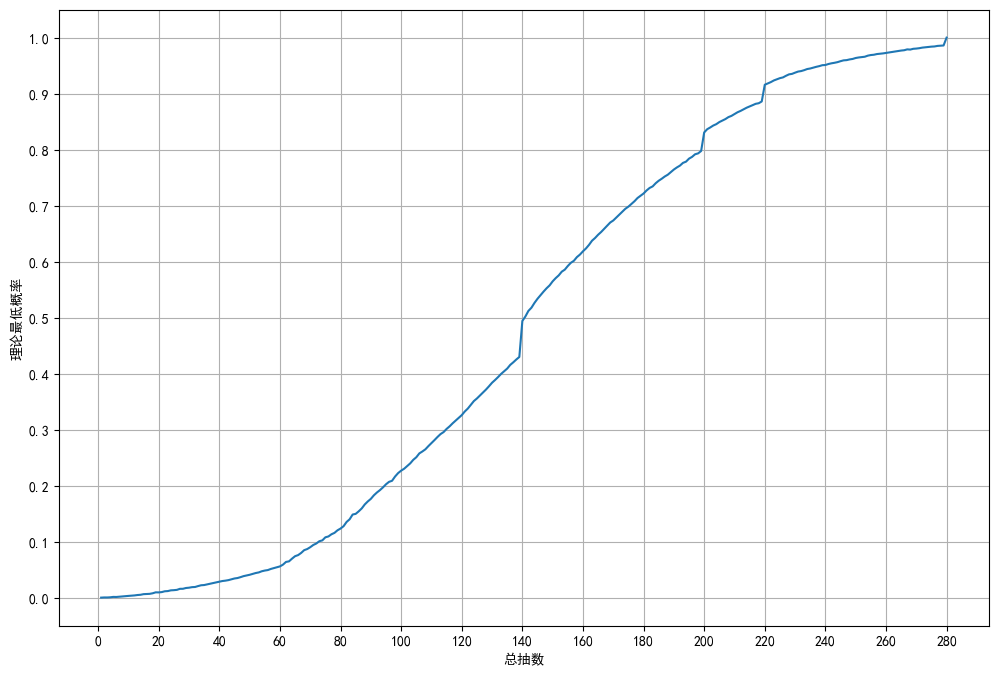

In [14]:
import matplotlib.pyplot

#set the environment variable KMP_DUPLICATE_LIB_OK=TRUE
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

#绘制最终概率随n_limit的变化
matplotlib.pyplot.rcParams["font.sans-serif"] = ["SimHei"]
matplotlib.pyplot.figure(figsize=(12, 8))
matplotlib.pyplot.xticks([i for i in range(0, 301, 20)])
matplotlib.pyplot.yticks([i / 10 for i in range(11)])
matplotlib.pyplot.xlabel("总抽数")
matplotlib.pyplot.ylabel("理论最低概率")
matplotlib.pyplot.grid(True)
matplotlib.pyplot.plot(results.index, results.values)